# Exercise 09: fastai_onnx_gradcam

***search for # TASK XX in the code and fill missing lines***

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Miro001/advanced-computer-vision/blob/main/9.%20%20GradCAM%20-%20onnx%20-%20fastai.ipynb)


## Install necessary dependencies
###  on Google Colab
1. Use GPU. Runtime -> Change runtime type -> Hardware accelerator -> GPU
2. Install dependencies from the following cell
3. Runtime -> Restart runtime

In [ ]:
!pip install light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install fastai --upgrade >> /.tmp
!pip install wandb
!pip install onnxruntime-gpu

### on local comp

In [ ]:
conda install -c fastai -c pytorch fastai
pip install wandb
pip install onnxruntime
pip install ipywidgets
pip install matplotlib

## Download dataset and import necessary libraries

In [4]:
from ipywidgets import IntSlider
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from fastai.vision.widgets import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb
import onnxruntime as ort
#wandb.init(anonymous='allow') # use wandb without an account 
wandb.init() # uncomment if you are a registered user

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Create Dataloader

In [5]:
# DOWNLOAD DATASET
path = untar_data(URLs.PETS)

In [6]:
files = get_image_files(path/"images")
SIZE = 224
files

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_146.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_104.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_121.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_101.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_26.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_102.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_113.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_266.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_191.jpg')...]

### TASK 01: name of the file is a class. fix a get_y oneliner method to transform string e.g. 'Abyssinian_106.jpg' into string(class) 'abyssinian' 


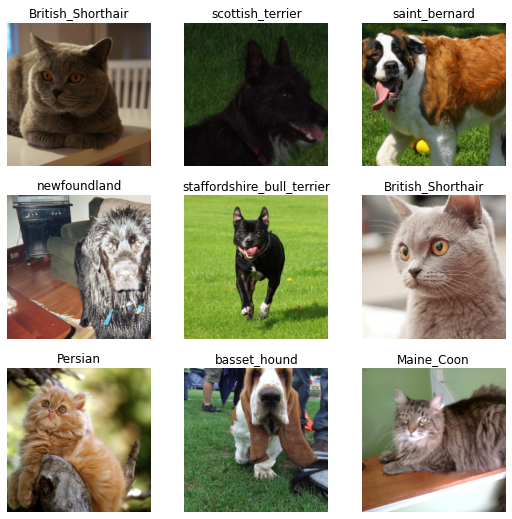

In [8]:
def get_y(f): return f[:f.rfind("_")]
dls = ImageDataLoaders.from_name_func(path, fnames=files, label_func=get_y, item_tfms=Resize(SIZE)) # add num_workers=0 when running on windows
classes = dls.vocab
dls.show_batch()

In [9]:
assert len(dls.train_ds.vocab) == 37, "Not correct number of classes"

### (OPTIONAL TASK) change resnet18 to other arch. Is the model improving with a change of the arch ? 


In [ ]:
dir(models)

## TRAIN on pretrained model


In [10]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy], cbs=[WandbCallback(), SaveModelCallback(monitor='error_rate', comp=np.less)])
# learn = cnn_learner(dls, ..., metrics=[error_rate, accuracy], cbs=[WandbCallback(), SaveModelCallback(monitor='error_rate', comp=np.less)]) 


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0030199517495930195)

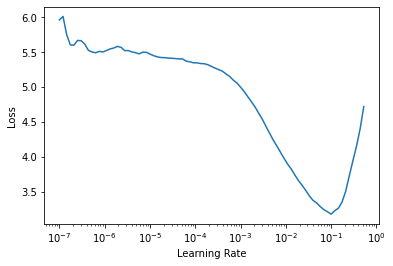

In [11]:
learn.lr_find()

In [12]:
learn.fine_tune(5, 3e-2, freeze_epochs=1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.259397,1.346990,0.238160,0.761840,00:45


Better model found at epoch 0 with error_rate value: 0.2381596714258194.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.321501,3.249434,0.441813,0.558187,00:46
1,1.224600,1.082333,0.296346,0.703654,00:47
2,0.675442,0.654885,0.190122,0.809878,00:46
3,0.313913,0.402147,0.115697,0.884303,00:46
4,0.140447,0.364039,0.102842,0.897158,00:46


Better model found at epoch 0 with error_rate value: 0.44181326031684875.
Better model found at epoch 1 with error_rate value: 0.29634642601013184.
Better model found at epoch 2 with error_rate value: 0.19012178480625153.
Better model found at epoch 3 with error_rate value: 0.11569688469171524.
Better model found at epoch 4 with error_rate value: 0.10284167528152466.


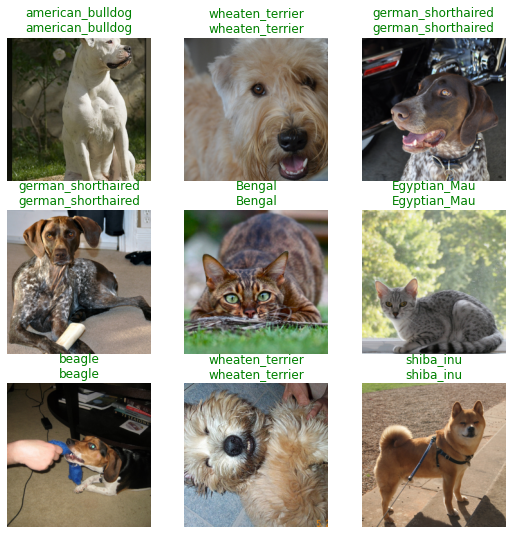

In [14]:
# INFERENCE
learn.show_results()
# If you experiment)
learn.export(fname='classifier.pkl')

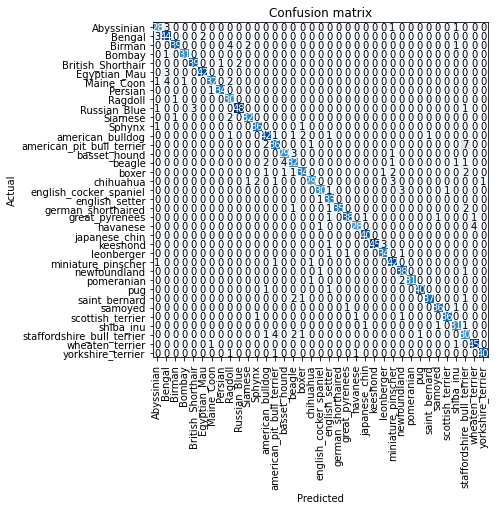

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

### TASK 02: based on the confusion matrix compute sensitivity and specificity of EACH class
***
Sensitivity (True Positive rate) measures the proportion of positives that are correctly identified. It is defined as follows:
$$sensitivity = \frac{true\_positive}{true\_positive + false\_negative}$$
Specificity (True Negative rate) measures the proportion of negatives that are correctly identified. It is defined as follows:
$$specificity = \frac{true\_negative}{true\_negative + false\_positive}$$
***
https://en.wikipedia.org/wiki/Sensitivity_and_specificity

HINT: https://stackoverflow.com/questions/55635406/how-to-calculate-multiclass-overall-accuracy-sensitivity-and-specificity

In [18]:
conf_mat = interp.confusion_matrix()

In [170]:
def counts_from_confusion(confusion,labels):
    """
    Obtain TP, FN FP, and TN for each class in the confusion matrix
    """

    counts_list = []

    # Iterate through classes and store the counts
    for i in range(confusion.shape[0]):
        tp = confusion[i, i]

        fn_mask = np.zeros(confusion.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion, fn_mask))

        fp_mask = np.zeros(confusion.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion, tn_mask))

        counts_list.append({'Class': labels[i],
                            'TP': tp,
                            'FN': fn,
                            'FP': fp,
                            'TN': tn})

    return counts_list

def print_sensitivity_and_specificity_of_each_class():
    counts = counts_from_confusion(conf_mat,dls.train_ds.vocab)
    Class = "Class"
    print(f"{Class: <{25}}" + "Sensitivity" + ("%15s" % "Specificity"))
    print("----------------------------------------------------")
    for pet in counts:
        pet_name = pet["Class"]
        pet_sensitivity = round(pet["TP"]/(pet["TP"]+pet["FN"]),5)
        pet_specificity = round(pet["TN"]/(pet["TN"]+pet["FP"]),5)
        print(f"{pet_name: <{28}}" + "%.2f" % pet_sensitivity + "%15s" % ("%.2f" % pet_specificity))


In [171]:
print_sensitivity_and_specificity_of_each_class()

Class                    Sensitivity    Specificity
----------------------------------------------------
Abyssinian                  0.85           1.00
Bengal                      0.90           0.99
Birman                      0.85           1.00
Bombay                      0.97           1.00
British_Shorthair           0.93           1.00
Egyptian_Mau                0.93           1.00
Maine_Coon                  0.80           1.00
Persian                     0.97           1.00
Ragdoll                     0.97           0.99
Russian_Blue                0.91           1.00
Siamese                     0.91           1.00
Sphynx                      0.95           1.00
american_bulldog            0.86           1.00
american_pit_bull_terrier   0.78           0.99
basset_hound                0.88           1.00
beagle                      0.78           0.99
boxer                       0.81           1.00
chihuahua                   0.78           1.00
english_cocker_spaniel      0.8

### TASK 03: compare inference times of the learn.predict and the onnx one. You can also use jupyter's %timeit, see: https://ipython.readthedocs.io/en/stable/interactive/magics.html

In [151]:
# ORIGINAL INFERENCE
%timeit learn.predict(files[0])

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 39.8 ms per loop


In [152]:
torch.onnx.export(
    learn.model,
    torch.randn(1, 3, SIZE, SIZE).cuda(), # The content of the tensor does not matter, but it needs to have the correct shape.
                                          # In particular, the first axis must be the batch size, even if it is 1. 
    "classifier.onnx",
    input_names=["image"],
    output_names=["diagnosis"]
)

In [154]:
# ONNX INFERENCE
session = ort.InferenceSession('classifier.onnx')
input_name = session.get_inputs()[0].name
img = PILImage.create(files[0])

%timeit session.run(None, {input_name: np.array(img.resize((SIZE,SIZE))).reshape(1,3,SIZE,SIZE).astype(np.float32)})


The slowest run took 16.03 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 4.63 ms per loop


## Grad CAM

### TASK 04: Debug get_cam_map method with jupyter's %debug
* 'up', 'down' is for moving in the call stack,
* 'list' shows code
* 'help' for more options
* try to print also some variables in the current call context

In [156]:
# grad cam
def get_cam_map(model, x, cls, layer=-2):
    with Hook(model[0][layer], lambda m, i, o: o[0].detach().clone(), is_forward=False) as hookg:
        with Hook(model[0][layer], lambda m, i, o: o.detach().clone(), is_forward=True) as hook:
            output = model.eval()(x.cuda())
            act = hook.stored
        output[0, cls].backward()
        grad = hookg.stored
    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    return cam_map.detach().cpu()

# merge image with heatmap
def merge_img_cam(image, cam_map):
    image = image.resize((SIZE, SIZE))
    # make a Figure and attach it to a canvas.
    fig = Figure(figsize=(SIZE/100, SIZE/100), dpi=100)
    canvas = FigureCanvasAgg(fig)
    ax = fig.subplots()
    # Do some plotting here
    show_image(image, ctx=ax)
    ax.axis('off')
    ax.imshow(cam_map, alpha=0.6, extent=(0,SIZE,SIZE,0), interpolation='bilinear', cmap='magma')

    # Retrieve a view on the renderer buffer
    canvas.draw()
    buf = canvas.buffer_rgba()
    # convert to a NumPy array
    X = np.asarray(buf)
    return X


## Simple site with widgets

In [157]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
grad_pl = widgets.Output()
lbl_pred = widgets.Label('Prediction: -; Probability: -')
grad_classes = Dropdown(options=classes, index=0)
grad_layer_slider = IntSlider(min=-5, max=-2, step=1, value=-2)

def prepare_image(img):
    return PILImage.create(np.array(PILImage.create(img).resize((SIZE,SIZE))))

def on_class_slider_change(change):
    grad_pl.clear_output()
    img = prepare_image(btn_upload.data[-1])
    x, = first(learn.dls.test_dl([img], rm_type_tfms=None, num_workers=0)) 
    with grad_pl:
        cam_map = get_cam_map(model=learn.model, x=x, cls=grad_classes.index, layer=grad_layer_slider.value)
        display(Image.fromarray(merge_img_cam(img, cam_map)))


def on_click(change):
    out_pl.clear_output()
    grad_pl.clear_output()
    img = prepare_image(btn_upload.data[-1])
    with out_pl: 
        display(img)
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {str(probs[pred_idx].numpy())}'
    x, = first(learn.dls.test_dl([img], rm_type_tfms=None, num_workers=0))
    
    with grad_pl:
        cam_map = get_cam_map(model=learn.model, x=x, cls=grad_classes.index)
        display(Image.fromarray(merge_img_cam(img, cam_map)))

btn_upload.observe(on_click, names=['data'])
grad_classes.observe(on_class_slider_change)
grad_layer_slider.observe(on_class_slider_change)

display(VBox([widgets.Label('Classify your cat or dog breed!'), 
              btn_upload, 
              out_pl, 
              lbl_pred, 
              HBox([widgets.Label('Grad Class Activation Map for class: '), grad_classes]), 
              HBox([widgets.Label('Grad Class Activation Map for model layer: '), grad_layer_slider]), 
              grad_pl]))

In [ ]:
%debug